In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings
warnings.filterwarnings('ignore')

Upload the data file from here first then comment out lines

In [2]:
 #from google.colab import files
 #uploaded = files.upload()

# Group 4 - Salary Data

The goal of this was to establish a classification model for salary prediction and assess its performance metrics and establish critical features correlated to higher salary.

### Importing the raw data

In [3]:
import pandas as pd
import io
rawDataset = pd.read_csv('adult_income.csv',na_values = "?", skipinitialspace = True)
# Dataset is now stored in a Pandas Dataframe

### Cleaning the data

In [4]:
# Some of the columns have ? so we need drop them these are now in the dataset variable
dataset = rawDataset[(rawDataset != ' ?').all(axis=1)]
dataset = rawDataset[(rawDataset != '?').all(axis=1)]

# Drop any duplicate rows
dataset = dataset.drop_duplicates()

dataset.head(5) # 30162 rows (lost 2402 rows)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# As education and education_num describe the same thing we can drop one of them
dataset = dataset.drop(['education-num'], axis = 1)

# Also relationship and marital-status describe the same thing so we can drop one of them
dataset = dataset.drop(['relationship'], axis = 1)

In [6]:
# As salary is either >50K or <=50K we need to change it to 1 and 0 so we can use it in the model
dataset['salary'] = dataset['salary'].map({'<=50K': 0, '>50K': 1})
dataset.head(5)

,age,workclass,education,marital-status,occupation,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,Bachelors,Never-married,Adm-clerical,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,White,Male,0,0,40,United-States,0
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Black,Female,0,0,40,Cuba,0


### Preliminary Analysis

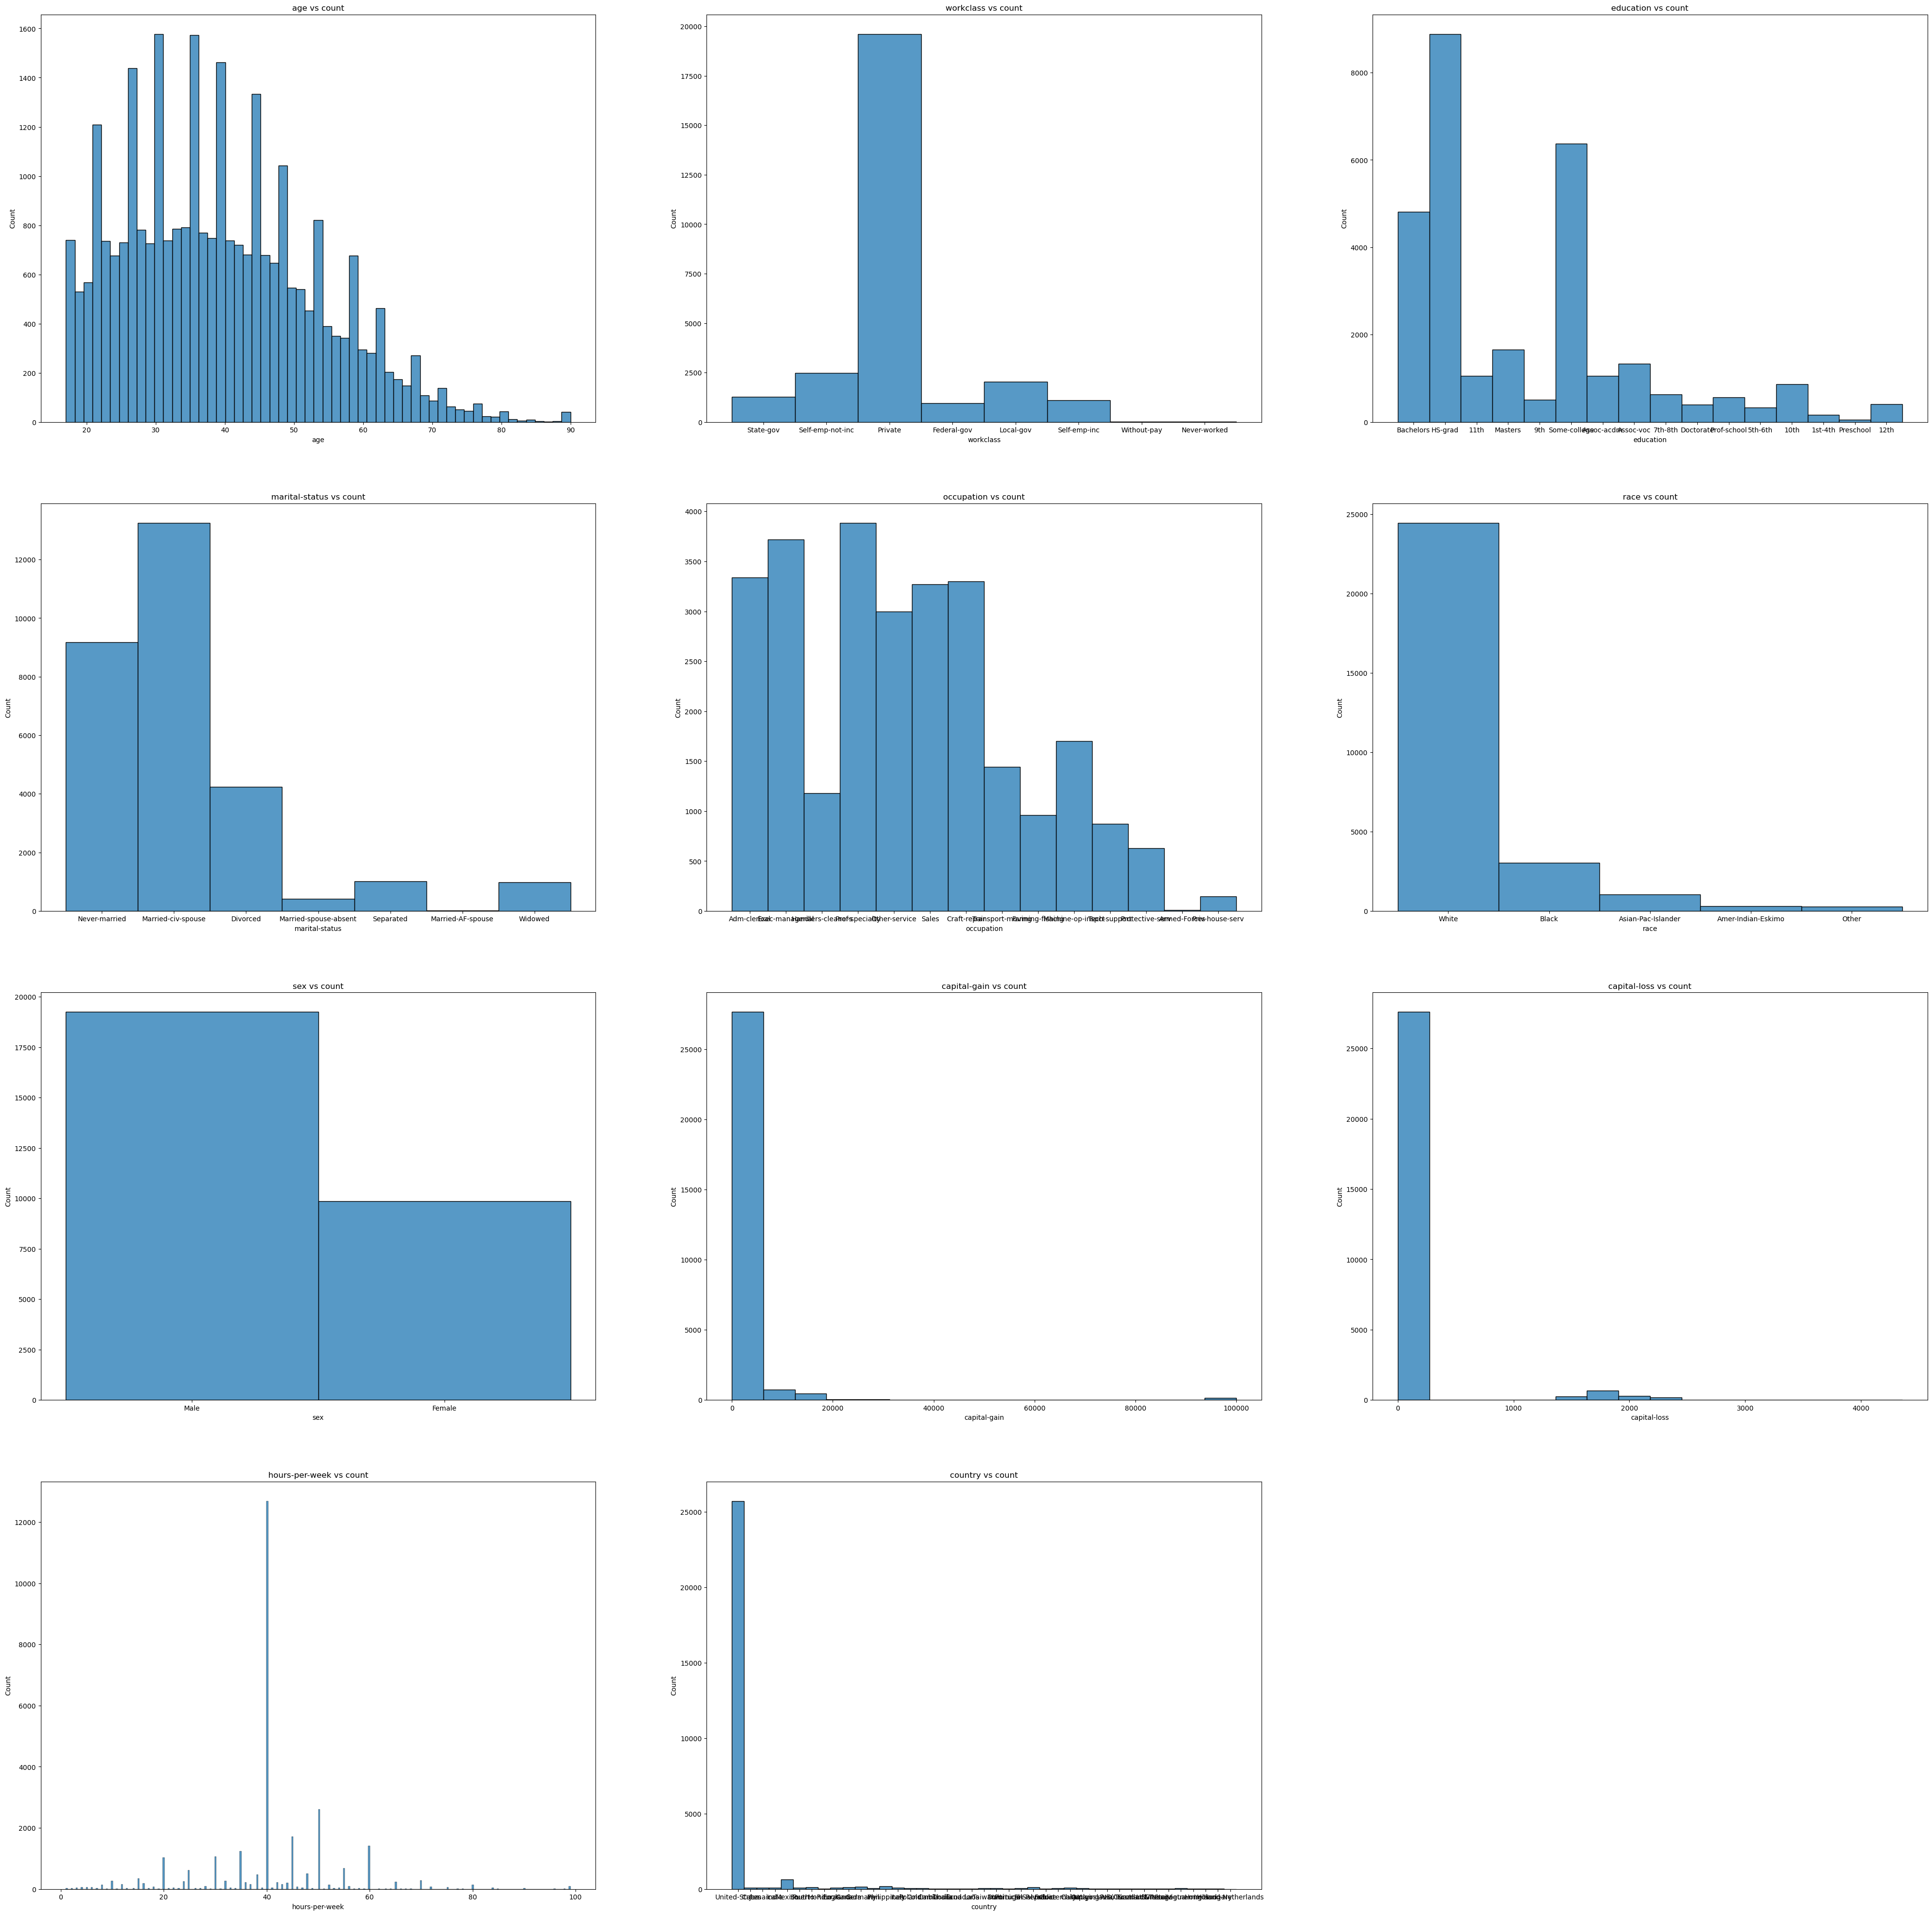

In [7]:
a=4
b=3
c=1
# Set figure size
fig = plt.figure(figsize=(50,50))

for i in dataset.columns:

    if i == 'salary':
        continue

    plt.subplot(a, b, c)
    plt.title('{} vs count'.format(i))
    plt.xlabel(i)
    sns.histplot(dataset[i])
    c = c + 1

From the distributions shown above it is clear to see that the data is not even and will have some inherent bias.

For example, the number of data points of people who are over 70 years old is very small compared to the number of people who are under 70 years old. This will cause the classification model to be biased towards the younger age group and will not be able to accurately predict the salary of the older age group.

In a similar fashion, there are almost 2x as many samples of males than females, this will create a bias towards males in our model. The same thing can be said about country of origin, where the United States has vastly more samples than any other country combined and consequently will be better at predicting salaries for people from the United States than any other country.

### Data analysis and visualization

To create our classification model we need to figure out what features are correlated to salary. We can create some visualizations to see if there are any obvious correlations.

As this dataset uses it uses a mixture of discrete and continuous variables finding the correlation will be difficult. One way to solve this is comparing the ratio of high/low earners against each discrete category. This will give us a rough idea of which categories are correlated to high earners.

In [8]:
# Looking at the workerclass feature against the number of high earners (1 = high earner, 0 = low earner)
workerclass = pd.crosstab(dataset['workclass'], dataset['salary'])

# Add the total column
workerclass['Total'] = workerclass.sum(axis = 1)

# Rename the 0 to low and 1 to high
workerclass = workerclass.rename(columns = {0: 'Lower than 50k', 1: 'Higher than 50k'})

# Add the percentage columns
workerclass['Lower than 50k %'] = round(workerclass['Lower than 50k'] / workerclass['Total'] * 100, 2)
workerclass['Higher than 50k %'] = round(workerclass['Higher than 50k'] / workerclass['Total'] * 100,2)

# Display the table
workerclass



salary,Lower than 50k,Higher than 50k,Total,Lower than 50k %,Higher than 50k %
workclass,,,,,
Federal-gov,584,362,946,61.73,38.27
Local-gov,1439,601,2040,70.54,29.46
Never-worked,7,0,7,100.00,0.00
Private,15224,4397,19621,77.59,22.41
Self-emp-inc,486,605,1091,44.55,55.45
Self-emp-not-inc,1765,708,2473,71.37,28.63
State-gov,924,348,1272,72.64,27.36
Without-pay,14,0,14,100.00,0.00


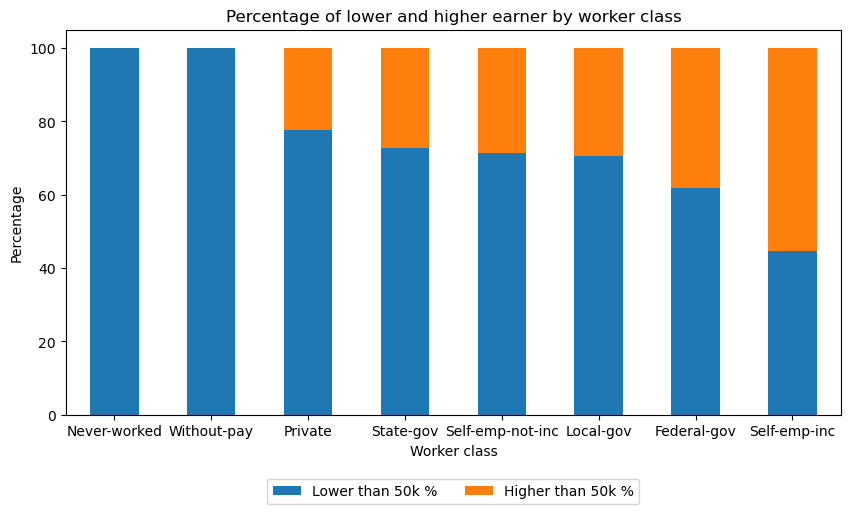

In [9]:
# Display the number of lower and higher earner by worker class in a bar chart normalised to 100%
# Sorted in ascending order of the higher earner percentage
workerclass[['Lower than 50k %', 'Higher than 50k %']].sort_values('Higher than 50k %').plot(kind = 'bar', stacked = True, figsize = (10, 5))

# Title and labels
plt.title('Percentage of lower and higher earner by worker class')
plt.xlabel('Worker class')
plt.ylabel('Percentage')

# Change x axis labels to horizontal
plt.xticks(rotation = 0)

# Move the legend to the bottom of the chart
plt.legend(loc = 'lower center', bbox_to_anchor = (0.5, -0.25), ncol = 2)


From this data it can be seen that there seems to be some correlation between the number of high earners and what sector they work in.

We can do similar analysis for the other discrete variables to see if there are any other correlations.

#### Education

In [10]:
# Looking at the Education feature against the number of high earners (1 = high earner, 0 = low earner)
education = pd.crosstab(dataset['education'], dataset['salary'])

# Add the total column
education['Total'] = education.sum(axis = 1)

# Rename the 0 to low and 1 to high
education = education.rename(columns = {0: 'Lower than 50k', 1: 'Higher than 50k'})

# Add the percentage columns
education['Lower than 50k %'] = round(education['Lower than 50k'] / education['Total'] * 100, 2)
education['Higher than 50k %'] = round(education['Higher than 50k'] / education['Total'] * 100,2)

# Display the table
education

salary,Lower than 50k,Higher than 50k,Total,Lower than 50k %,Higher than 50k %
education,,,,,
10th,808,59,867,93.19,6.81
11th,996,60,1056,94.32,5.68
12th,381,33,414,92.03,7.97
1st-4th,160,6,166,96.39,3.61
5th-6th,312,16,328,95.12,4.88
7th-8th,589,40,629,93.64,6.36
9th,480,27,507,94.67,5.33
Assoc-acdm,789,264,1053,74.93,25.07
Assoc-voc,981,350,1331,73.70,26.30


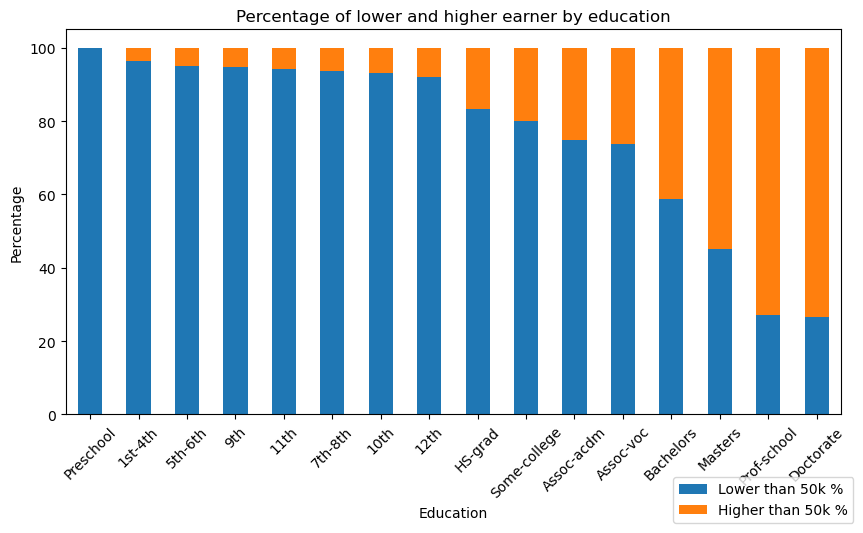

In [11]:
# Display the number of lower and higher earner by education in a bar chart normalised to 100%
# Sorted in ascending order of the higher earner percentage
education[['Lower than 50k %', 'Higher than 50k %']].sort_values('Higher than 50k %').plot(kind = 'bar', stacked = True, figsize = (10, 5))

# Title and labels
plt.title('Percentage of lower and higher earner by education')
plt.xlabel('Education')
plt.ylabel('Percentage')

# Change x axis labels to 45 degrees
plt.xticks(rotation = 45)

# Move the legend to the lower right of the chart
plt.legend(loc = 'lower center', bbox_to_anchor = (0.9, -0.3), ncol = 1)

Looking at education it can be seen that there is a correlation between the number of high earners and the level of education. This makes sense as the higher the level of education the more likely you are to get a higher paying job.

#### Marital Status

In [12]:
# Looking at the marital-status feature against the number of high earners (1 = high earner, 0 = low earner)
maritalstatus = pd.crosstab(dataset['marital-status'], dataset['salary'])

# Add the total column
maritalstatus['Total'] = maritalstatus.sum(axis = 1)

# Rename the 0 to low and 1 to high
maritalstatus = maritalstatus.rename(columns = {0: 'Lower than 50k', 1: 'Higher than 50k'})

# Add the percentage columns
maritalstatus['Lower than 50k %'] = round(maritalstatus['Lower than 50k'] / maritalstatus['Total'] * 100, 2)
maritalstatus['Higher than 50k %'] = round(maritalstatus['Higher than 50k'] / maritalstatus['Total'] * 100,2)

# Display the table
maritalstatus

salary,Lower than 50k,Higher than 50k,Total,Lower than 50k %,Higher than 50k %
marital-status,,,,,
Divorced,3777,460,4237,89.14,10.86
Married-AF-spouse,13,10,23,56.52,43.48
Married-civ-spouse,7178,6071,13249,54.18,45.82
Married-spouse-absent,384,34,418,91.87,8.13
Never-married,8688,485,9173,94.71,5.29
Separated,948,66,1014,93.49,6.51
Widowed,898,84,982,91.45,8.55


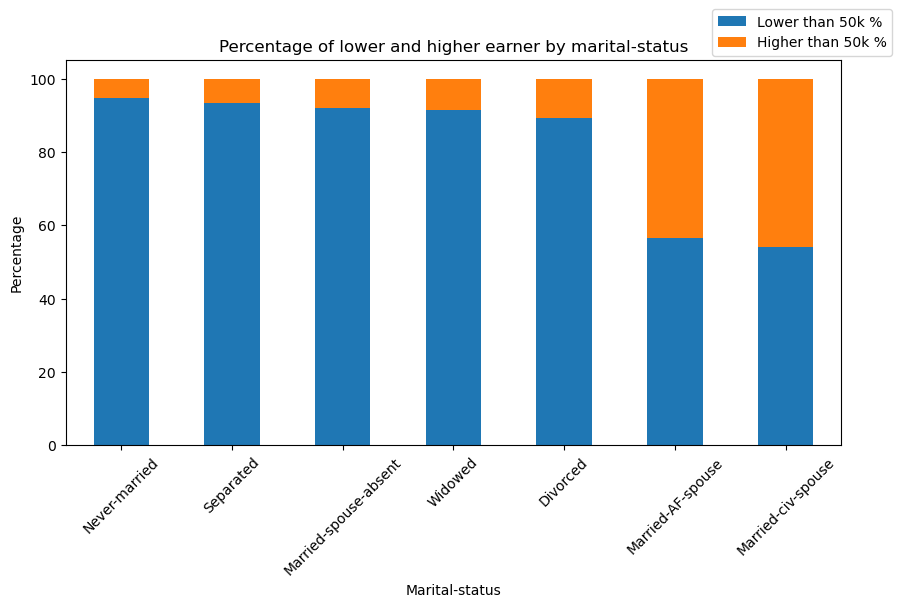

In [13]:
# Display the number of lower and higher earner by marital-status in a bar chart normalised to 100%
# Sorted in ascending order of the higher earner percentage
maritalstatus[['Lower than 50k %', 'Higher than 50k %']].sort_values('Higher than 50k %').plot(kind = 'bar', stacked = True, figsize = (10, 5))

# Title and labels
plt.title('Percentage of lower and higher earner by marital-status')
plt.xlabel('Marital-status')
plt.ylabel('Percentage')

# Change x axis labels to 45 degrees
plt.xticks(rotation = 45)

# Move the legend to the upper right of the chart
plt.legend(loc = 'upper center', bbox_to_anchor = (0.95, 1.15), ncol = 1)

Here we can see that the marital status of the employee does seem to have an effect on the number of high earners.

#### Occupation

In [14]:
# Looking at the occupation feature against the number of high earners (1 = high earner, 0 = low earner)
occupation = pd.crosstab(dataset['occupation'], dataset['salary'])

# Add the total column
occupation['Total'] = occupation.sum(axis = 1)

# Rename the 0 to low and 1 to high
occupation = occupation.rename(columns = {0: 'Lower than 50k', 1: 'Higher than 50k'})

# Add the percentage columns
occupation['Lower than 50k %'] = round(occupation['Lower than 50k'] / occupation['Total'] * 100, 2)
occupation['Higher than 50k %'] = round(occupation['Higher than 50k'] / occupation['Total'] * 100,2)

# Display the table
occupation

salary,Lower than 50k,Higher than 50k,Total,Lower than 50k %,Higher than 50k %
occupation,,,,,
Adm-clerical,2856,484,3340,85.51,14.49
Armed-Forces,8,1,9,88.89,11.11
Craft-repair,2520,778,3298,76.41,23.59
Exec-managerial,1946,1773,3719,52.33,47.67
Farming-fishing,848,114,962,88.15,11.85
Handlers-cleaners,1098,81,1179,93.13,6.87
Machine-op-inspct,1474,228,1702,86.60,13.40
Other-service,2859,137,2996,95.43,4.57
Priv-house-serv,146,1,147,99.32,0.68


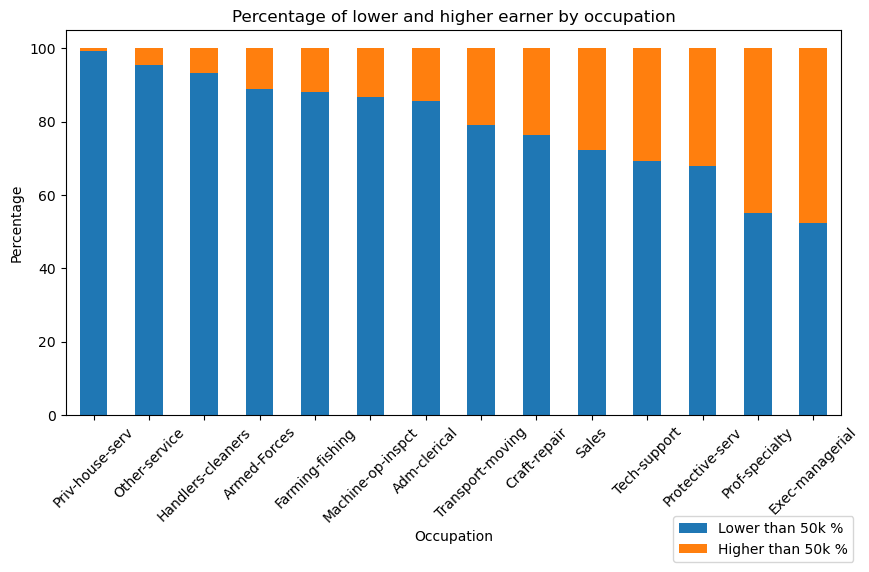

In [15]:
# Display the number of lower and higher earner by occupation in a bar chart normalised to 100%
# Sorted in ascending order of the higher earner percentage
occupation[['Lower than 50k %', 'Higher than 50k %']].sort_values('Higher than 50k %').plot(kind = 'bar', stacked = True, figsize = (10, 5))

# Title and labels
plt.title('Percentage of lower and higher earner by occupation')
plt.xlabel('Occupation')
plt.ylabel('Percentage')

# Change x axis labels to 45 degrees
plt.xticks(rotation = 45)

# Move the legend to the lower right of the chart
plt.legend(loc = 'lower center', bbox_to_anchor = (0.9, -0.4), ncol = 1)

Here we can see a clear correlation between the occupation of the employee and the number of high earners. This makes sense as some occupations are more likely to have higher salaries than others.

#### Race

In [16]:
# Looking at the race feature against the number of high earners (1 = high earner, 0 = low earner)
race = pd.crosstab(dataset['race'], dataset['salary'])

# Add the total column
race['Total'] = race.sum(axis = 1)

# Rename the 0 to low and 1 to high
# Rename the 0 to low and 1 to high
race = race.rename(columns = {0: 'Lower than 50k', 1: 'Higher than 50k'})

# Add the percentage columns
race['Lower than 50k %'] = round(race['Lower than 50k'] / race['Total'] * 100, 2)
race['Higher than 50k %'] = round(race['Higher than 50k'] / race['Total'] * 100,2)

# Display the table
race

salary,Lower than 50k,Higher than 50k,Total,Lower than 50k %,Higher than 50k %
race,,,,,
Amer-Indian-Eskimo,275,36,311,88.42,11.58
Asian-Pac-Islander,762,276,1038,73.41,26.59
Black,2654,384,3038,87.36,12.64
Other,246,25,271,90.77,9.23
White,17949,6489,24438,73.45,26.55


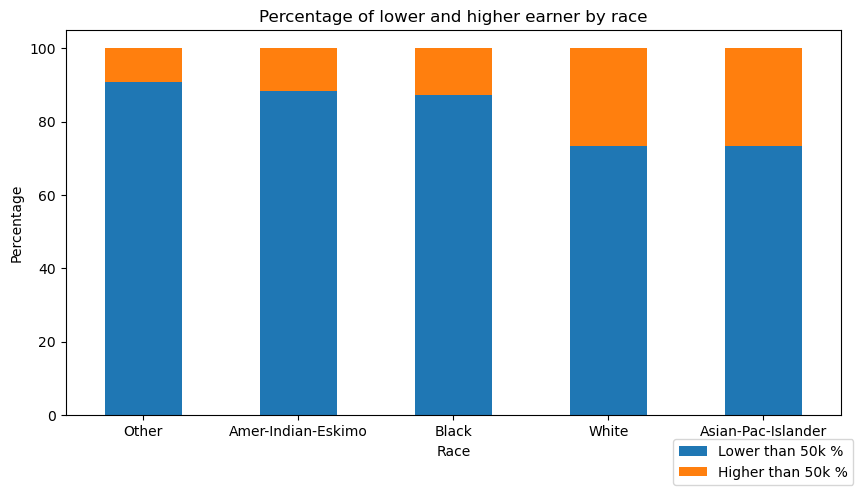

In [17]:
# Display the number of lower and higher earner by race in a bar chart normalised to 100%
# Sorted in ascending order of the higher earner percentage
race[['Lower than 50k %', 'Higher than 50k %']].sort_values('Higher than 50k %').plot(kind = 'bar', stacked = True, figsize = (10, 5))

# Title and labels
plt.title('Percentage of lower and higher earner by race')
plt.xlabel('Race')
plt.ylabel('Percentage')

# Change x axis labels to horizontal
plt.xticks(rotation = 0)

# Move the legend to the lower right of the chart
plt.legend(loc = 'lower center', bbox_to_anchor = (0.9, -0.2), ncol = 1)

Here it seems that there is no significant impact by race

#### Sex

In [18]:
# Looking at the sex feature against the number of high earners (1 = high earner, 0 = low earner)
sex = pd.crosstab(dataset['sex'], dataset['salary'])

# Add the total column
sex['Total'] = sex.sum(axis = 1)

# Rename the 0 to low and 1 to high
# Rename the 0 to low and 1 to high
sex = sex.rename(columns = {0: 'Lower than 50k', 1: 'Higher than 50k'})

# Add the percentage columns
sex['Lower than 50k %'] = round(sex['Lower than 50k'] / sex['Total'] * 100, 2)
sex['Higher than 50k %'] = round(sex['Higher than 50k'] / sex['Total'] * 100,2)

# Display the table
sex

salary,Lower than 50k,Higher than 50k,Total,Lower than 50k %,Higher than 50k %
sex,,,,,
Female,8698,1152,9850,88.30,11.70
Male,13188,6058,19246,68.52,31.48


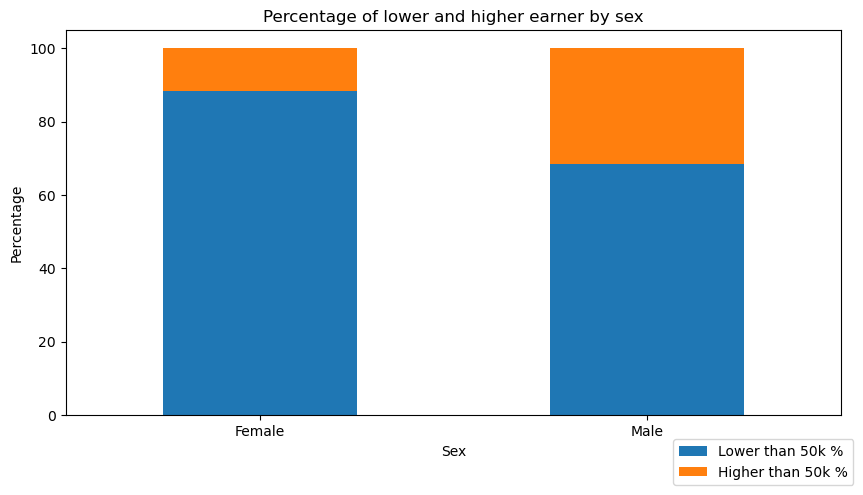

In [19]:
# Display the number of lower and higher earner by sex in a bar chart normalised to 100%
# Sorted in ascending order of the higher earner percentage
sex[['Lower than 50k %', 'Higher than 50k %']].sort_values('Higher than 50k %').plot(kind = 'bar', stacked = True, figsize = (10, 5))

# Title and labels
plt.title('Percentage of lower and higher earner by sex')
plt.xlabel('Sex')
plt.ylabel('Percentage')

# Change x axis labels to horizontal
plt.xticks(rotation = 0)

# Move the legend to the lower right of the chart
plt.legend(loc = 'lower center', bbox_to_anchor = (0.9, -0.2), ncol = 1)

Here it seems that males earn slightly more.

#### Country

In [20]:
# Looking at the country feature against the number of high earners (1 = high earner, 0 = low earner)
country = pd.crosstab(dataset['country'], dataset['salary'])

# Add the total column
country['Total'] = country.sum(axis = 1)

# Rename the 0 to low and 1 to high
country = country.rename(columns = {0: 'Lower than 50k', 1: 'Higher than 50k'})

# Add the percentage columns
country['Lower than 50k %'] = round(country['Lower than 50k'] / country['Total'] * 100, 2)
country['Higher than 50k %'] = round(country['Higher than 50k'] / country['Total'] * 100,2)

# Display the table
country

salary,Lower than 50k,Higher than 50k,Total,Lower than 50k %,Higher than 50k %
country,,,,,
Cambodia,12,7,19,63.16,36.84
Canada,82,39,121,67.77,32.23
China,55,20,75,73.33,26.67
Columbia,57,2,59,96.61,3.39
Cuba,70,25,95,73.68,26.32
Dominican-Republic,68,2,70,97.14,2.86
Ecuador,24,4,28,85.71,14.29
El-Salvador,97,9,106,91.51,8.49
England,60,30,90,66.67,33.33


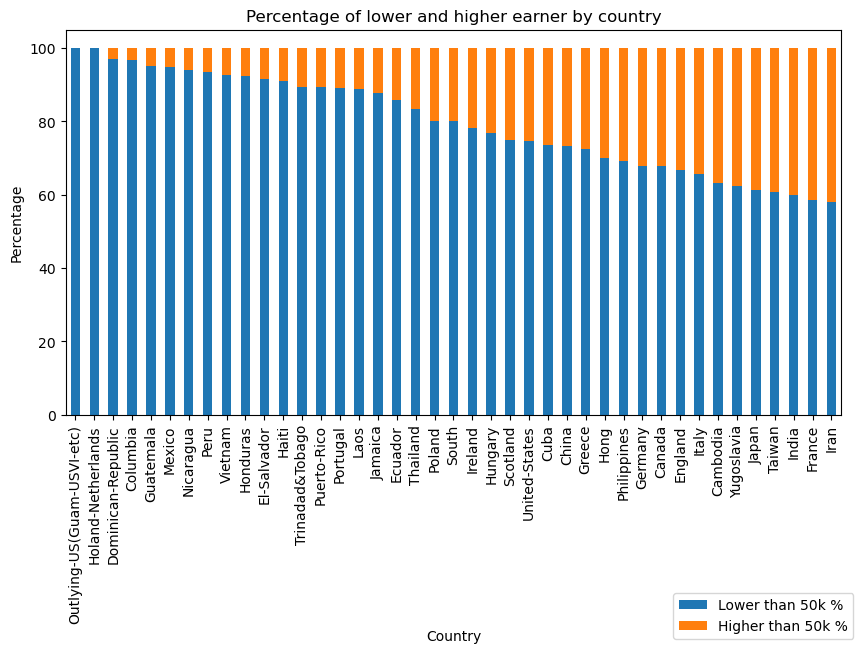

In [21]:
# Display the number of lower and higher earner by country in a bar chart normalised to 100%
# Sorted in ascending order of the higher earner percentage
country[['Lower than 50k %', 'Higher than 50k %']].sort_values('Higher than 50k %').plot(kind = 'bar', stacked = True, figsize = (10, 5))

# Title and labels
plt.title('Percentage of lower and higher earner by country')
plt.xlabel('Country')
plt.ylabel('Percentage')

# Change x axis labels to horizontal
plt.xticks(rotation = 90)

# Move the legend to the lower right of the chart
plt.legend(loc = 'lower center', bbox_to_anchor = (0.9, -0.6), ncol = 1)

Here there seems to be a clear correlation between the country of origin and the number of high earners. This makes sense as some countries are more developed than others and therefore have higher salaries.

#### Age

Text(0, 0.5, 'Age')

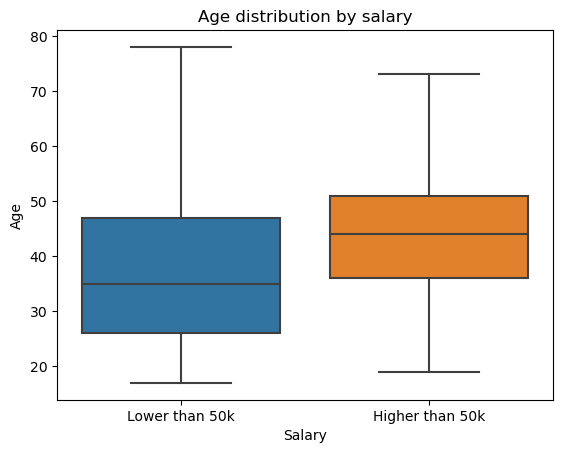

In [22]:
# Box plot of the age feature against the salary feature
sns.boxplot(x = 'salary', y = 'age', data = dataset, showfliers = False)


# Change the x axis labels to low and high
plt.xticks([0, 1], ['Lower than 50k', 'Higher than 50k'])

# Title and labels
plt.title('Age distribution by salary')
plt.xlabel('Salary')
plt.ylabel('Age')

From this it is clear to see that higher earners tend to be older. This makes sense as people tend to earn more as they get older.

#### Hours per week

Text(0, 0.5, 'Age')

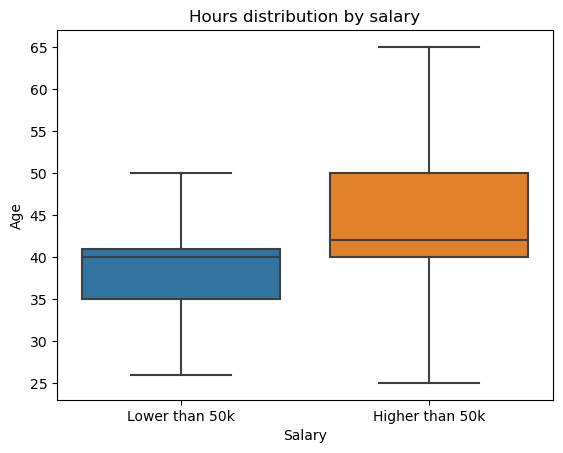

In [23]:
# Box plot of the hours feature against the salary feature
sns.boxplot(x = 'salary', y = 'hours-per-week', data = dataset, showfliers = False)

# Change the x axis labels to low and high
plt.xticks([0, 1], ['Lower than 50k', 'Higher than 50k'])

# Title and labels
plt.title('Hours distribution by salary')
plt.xlabel('Salary')
plt.ylabel('Age')

Here it can be seen that people who work more hours per week tend to earn more. This makes sense as people who work more hours tend to earn more.

In [24]:
##Check for duplicated data
dataset.duplicated().any()

True

In [25]:
##Remove duplicates
dataset=dataset.drop_duplicates()

In [26]:
dataset.head(5)

,age,workclass,education,marital-status,occupation,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,Bachelors,Never-married,Adm-clerical,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,White,Male,0,0,40,United-States,0
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Black,Female,0,0,40,Cuba,0


In [27]:
##Rename stuff so easier to work with
dataset.rename(columns={'marital-status': 'maritalStatus', 'hours-per-week': 'hoursPerWeek'}, inplace=True)

In [28]:
##Encode features - convert everything to nums - scaled 
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
dataset.workclass=lb.fit_transform(dataset.workclass)
dataset.education=lb.fit_transform(dataset.education)
dataset.maritalStatus=lb.fit_transform(dataset.maritalStatus)
dataset.occupation=lb.fit_transform(dataset.occupation)
dataset.race=lb.fit_transform(dataset.race)
dataset.sex=lb.fit_transform(dataset.sex)
dataset.country=lb.fit_transform(dataset.country)
dataset.head()


,age,workclass,education,maritalStatus,occupation,race,sex,capital-gain,capital-loss,hoursPerWeek,country,salary
0,39,6,9,4,0,4,1,2174,0,40,38,0
1,50,5,9,2,3,4,1,0,0,13,38,0
2,38,3,11,0,5,4,1,0,0,40,38,0
3,53,3,1,2,5,2,1,0,0,40,38,0
4,28,3,9,2,9,2,0,0,0,40,4,0


In [29]:
##Split data
from sklearn.model_selection import train_test_split 

y = dataset["salary"]
X = dataset.drop("salary", axis=1)
X.head()


,age,workclass,education,maritalStatus,occupation,race,sex,capital-gain,capital-loss,hoursPerWeek,country
0,39,6,9,4,0,4,1,2174,0,40,38
1,50,5,9,2,3,4,1,0,0,13,38
2,38,3,11,0,5,4,1,0,0,40,38
3,53,3,1,2,5,2,1,0,0,40,38
4,28,3,9,2,9,2,0,0,0,40,4


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52)

In [31]:
x_train_num = len(X_train)

In [32]:
x_test_num = len(X_test)

79.99929189682007
20.00070810317993


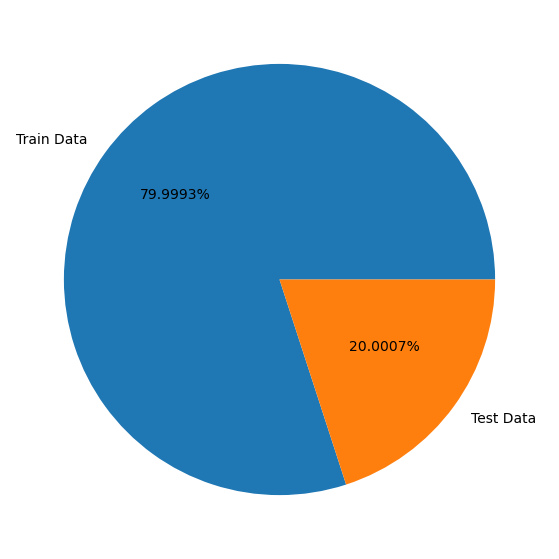

In [33]:
# Import libraries
from matplotlib import pyplot as plt
import numpy as np

 
# Creating dataset
cars = ['Train Data', 'Test Data']
 
data = [x_train_num, x_test_num]
 
def my_fmt(x):
    print(x)
    return '{:.4f}%\n'.format(x)

total = len(data)    
# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = cars, autopct=my_fmt)

# show plot
plt.show()

RF

In [34]:
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import train_test_split,KFold,GridSearchCV
#clf=RandomForestClassifier()
#kf=KFold(n_splits=3)
#max_features=np.array([1,2,3,4,5])
#n_estimators=np.array([50,100,150,200])
#min_samples_leaf=np.array([50,75,100,150])
#param_grid=dict(n_estimators=n_estimators,max_features=max_features,min_samples_leaf=min_samples_leaf)
#grid=GridSearchCV(estimator=clf,param_grid=param_grid,cv=kf)
#gres=grid.fit(X_train,y_train)
#print("Best",gres.best_score_)
#print("params",gres.best_params_)

In [35]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_features= 5, min_samples_leaf= 50, n_estimators= 50)
rfc.fit(X_train,y_train)
rfcpredict = rfc.predict(X_test)
rfc.score(X_test,y_test)


0.8501063075832743

In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_test, rfcpredict))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4181
           1       0.79      0.58      0.67      1463

    accuracy                           0.85      5644
   macro avg       0.83      0.76      0.78      5644
weighted avg       0.84      0.85      0.84      5644



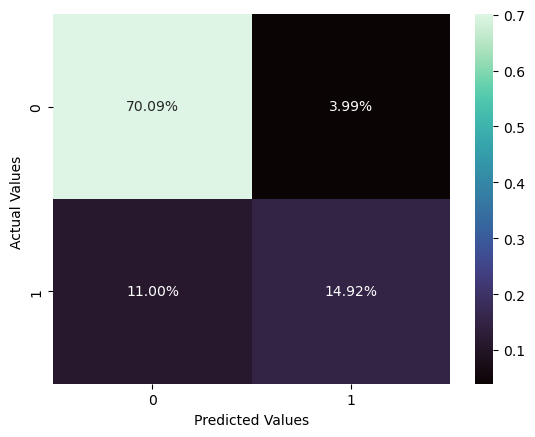

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
confusionMatrix = confusion_matrix(y_test, rfcpredict)

ax = sns.heatmap(confusionMatrix/np.sum(confusionMatrix), annot=True,  fmt='.2%', cmap='mako')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

plt.show()

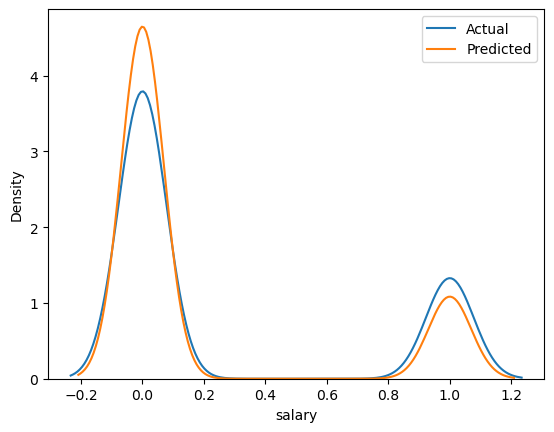

In [38]:

ax=sns.distplot(y_test,hist=False,label='Actual')
ax=sns.distplot(rfcpredict,hist=False,label='Predicted')
plt.legend()

[Text(0.7155138001824818, 0.975, 'x[9] <= 43.5\ngini = 0.379\nsamples = 14239\nvalue = [16844, 5731]'),
 Text(0.5168282390510949, 0.925, 'x[7] <= 5119.0\ngini = 0.306\nsamples = 9854\nvalue = [12670, 2950]'),
 Text(0.3679630474452555, 0.875, 'x[3] <= 2.5\ngini = 0.266\nsamples = 9445\nvalue = [12611, 2361]'),
 Text(0.18264142335766423, 0.825, 'x[8] <= 1793.5\ngini = 0.391\nsamples = 5138\nvalue = [5996, 2181]'),
 Text(0.12760036496350366, 0.775, 'x[2] <= 6.5\ngini = 0.369\nsamples = 4911\nvalue = [5899, 1907]'),
 Text(0.035036496350364967, 0.725, 'x[0] <= 39.5\ngini = 0.126\nsamples = 801\nvalue = [1210, 88]'),
 Text(0.01167883211678832, 0.675, 'x[4] <= 3.5\ngini = 0.029\nsamples = 285\nvalue = [473, 7]'),
 Text(0.00583941605839416, 0.625, 'gini = 0.059\nsamples = 99\nvalue = [158, 5]'),
 Text(0.017518248175182483, 0.625, 'x[2] <= 1.5\ngini = 0.013\nsamples = 186\nvalue = [315, 2]'),
 Text(0.01167883211678832, 0.575, 'gini = 0.0\nsamples = 94\nvalue = [167, 0]'),
 Text(0.02335766423357

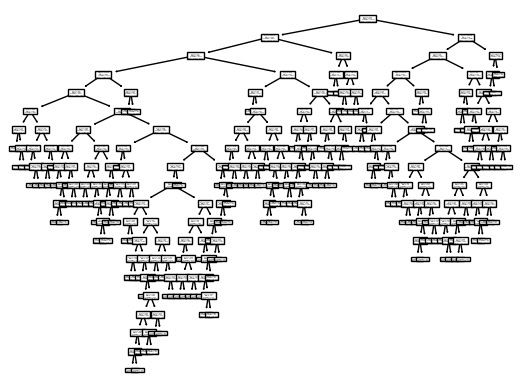

In [39]:
from sklearn import tree
tree.plot_tree(rfc.estimators_[10])

In [40]:
# From the random forest classifier, show the most important features
feature_importances = pd.DataFrame(rfc.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
maritalStatus,0.308605
capital-gain,0.295165
education,0.100586
age,0.087455
capital-loss,0.073955
hoursPerWeek,0.058984
occupation,0.040814
sex,0.021076
workclass,0.011048
race,0.001730


## Summary
Looking at the above visualizations it can be seen that there are some correlations between the features and the number of high earners. This means that these features will be useful in predicting the salary of an employee.

The features that seem to be correlated to the number of high earners are:
- Age
- Work Class
- Education
- Marital Status
- Occupation
- Sex
- Hours per week
- Country

These features will be used to create our classification model.